In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/MyDrive/colab_projects/recommendation_system/nbs/

/content/gdrive/MyDrive/colab_projects/recommendation_system/nbs


In [3]:
import sys
sys.path.append("../src/")
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from config import *

In [4]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [5]:
df_train = pd.read_parquet("../data/processed/df_rating_movie_train.parquet")
df_val = pd.read_parquet("../data/processed/df_rating_movie_val.parquet")

In [6]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres
5355991,34760,4963,4.0,1008626350,Ocean's Eleven (2001),Crime|Thriller
16979199,110106,1183,1.5,1301889569,"English Patient, The (1996)",Drama|Romance|War
14781790,95711,4571,2.0,1009726295,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
5159343,33523,1411,4.0,1039513864,Hamlet (1996),Crime|Drama|Romance
18503349,119883,33660,4.0,1353051590,Cinderella Man (2005),Drama|Romance


In [7]:
movies_ids = list(set(list(df_train.movieId.unique()) + list(df_val.movieId.unique())))

In [8]:
users_ids = list(set(list(df_train.userId.unique()) + list(df_val.userId.unique())))

In [9]:
len(movies_ids)

59047

In [10]:
max(movies_ids)

209171

In [11]:
dict_movies = {}
index = 0
for ids in sorted(movies_ids):
    dict_movies[ids] = index
    index += 1

In [12]:
dict_users = {}
index = 0
for ids in sorted(users_ids):
    dict_users[ids] = index
    index += 1

In [13]:
df_train["movieId"] = df_train["movieId"].map(dict_movies)
df_val["movieId"] = df_val["movieId"].map(dict_movies)

df_train["userId"] = df_train["userId"].map(dict_users)
df_val["userId"] = df_val["userId"].map(dict_users)

In [14]:
df_train.describe()

,userId,movieId,rating,timestamp
count,2.000008e+07,2.000008e+07,2.000008e+07,2.000008e+07
mean,8.118888e+04,6.107920e+03,3.533854e+00,1.215613e+09
std,4.679203e+04,8.262760e+03,1.060744e+00,2.268744e+08
min,0.000000e+00,0.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.167000e+03,3.000000e+00,1.011760e+09
50%,8.091300e+04,2.855000e+03,3.500000e+00,1.198869e+09
75%,1.215560e+05,7.920000e+03,4.000000e+00,1.447207e+09
max,1.625400e+05,5.904600e+04,5.000000e+00,1.574328e+09


In [15]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres
5355991,34759,4857,4.0,1008626350,Ocean's Eleven (2001),Crime|Thriller
16979199,110105,1154,1.5,1301889569,"English Patient, The (1996)",Drama|Romance|War
14781790,95710,4466,2.0,1009726295,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
5159343,33522,1373,4.0,1039513864,Hamlet (1996),Crime|Drama|Romance
18503349,119882,9979,4.0,1353051590,Cinderella Man (2005),Drama|Romance


In [16]:
df_train.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object

In [17]:
for col in ["userId", "movieId", "rating"]:
    df_train[col] = df_train[col].astype(np.float32)
    df_val[col] = df_val[col].astype(np.float32)

In [18]:
num_unique_users=len(set(list(df_train.userId.unique()) + list(df_val.userId.unique())))
num_unique_movies=len(set(list(df_train.movieId.unique()) + list(df_val.movieId.unique())))

In [19]:
min_rating=min(df_train.rating.min(), df_val.rating.min())
max_rating=max(df_train.rating.max(), df_val.rating.max())

In [20]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Embedding, multiply, concatenate, Flatten, Input, Dense

In [21]:
users_input = Input(shape=(1,), name="users_input")
users_embedding = Embedding(num_unique_users + 1, EMBEDDING_SIZE, name="users_embeddings")(users_input)
users_bias = Embedding(num_unique_users + 1, 1, name="users_bias")(users_input)

movies_input = Input(shape=(1,), name="movies_input")
movies_embedding = Embedding(num_unique_movies + 1, EMBEDDING_SIZE, name="movies_embeddings")(movies_input)
movies_bias = Embedding(num_unique_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = multiply([users_embedding, movies_embedding])

input_terms = dot_product_users_movies + users_bias + movies_bias

input_terms = Flatten(name="fl_inputs")(input_terms)

output = Dense(1, activation="sigmoid", name="output")(input_terms) 
output = output * (max_rating - min_rating) + min_rating

In [22]:
model = Model(inputs=[users_input, movies_input], outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embeddings (Embedding)    (None, 1, 50)        8127100     users_input[0][0]                
__________________________________________________________________________________________________
movies_embeddings (Embedding)   (None, 1, 50)        2952400     movies_input[0][0]               
______________________________________________________________________________________________

In [24]:
opt_adam = opt.Adam(lr = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

In [24]:
model.fit(x=[df_train.userId, df_train.movieId], y=df_train.rating, batch_size=2048, epochs=3, verbose=1,    
          validation_data=([df_val.userId, df_val.movieId], df_val.rating))

Epoch 1/3
9766/9766 [==============================] - 600s 61ms/step - loss: 0.7700 - mean_absolute_error: 0.6722 - val_loss: 0.6254 - val_mean_absolute_error: 0.5998
Epoch 2/3
9766/9766 [==============================] - 588s 60ms/step - loss: 0.5347 - mean_absolute_error: 0.5544 - val_loss: 0.6104 - val_mean_absolute_error: 0.5910
Epoch 3/3
9766/9766 [==============================] - 566s 58ms/step - loss: 0.4472 - mean_absolute_error: 0.5053 - val_loss: 0.6192 - val_mean_absolute_error: 0.5949


In [25]:
model.predict([df_val.userId, df_val.movieId])

array([[3.1722398],
       [4.3071613],
       [4.442726 ],
       ...,
       [3.576826 ],
       [4.433735 ],
       [4.0743356]], dtype=float32)

In [26]:
pd.DataFrame(model.predict([df_val.userId, df_val.movieId])).describe()

,0
count,5.000019e+06
mean,3.536497e+00
std,7.813966e-01
min,5.006742e-01
25%,3.071321e+00
50%,3.650293e+00
75%,4.122599e+00
max,4.999381e+00


In [27]:
model.save_weights("../model/neural_collab_filtering_min_max_v1.h5")

In [25]:
model.load_weights("../model/neural_collab_filtering_min_max_v1.h5")

In [26]:
for layer in model.layers:
    print(layer.name)

users_input
movies_input
users_embeddings
movies_embeddings
multiply
users_bias
tf.__operators__.add
movies_bias
tf.__operators__.add_1
fl_inputs
output
tf.math.multiply
tf.__operators__.add_2


In [27]:
dict_weights = {}
for layer in model.layers:
    if layer.name in ["users_embeddings", "movies_embeddings"]:
        dict_weights[layer.name] = layer.weights

In [30]:
dict_weights

{'movies_embeddings': [<tf.Variable 'movies_embeddings/embeddings:0' shape=(59048, 50) dtype=float32, numpy=
  array([[ 1.0267459e+00, -1.3984728e+00,  9.5613635e-01, ...,
          -8.4093440e-01,  8.4898537e-01, -2.1363454e+00],
         [ 8.9872265e-01, -1.2944645e-02, -3.8406596e-01, ...,
           7.1511030e-01,  9.1650999e-01, -4.9048254e-01],
         [-2.1096662e-01, -1.2351556e-02, -1.1073297e+00, ...,
          -3.8032055e-02,  1.4504491e+00,  3.5762182e-01],
         ...,
         [ 1.4339294e-02, -1.8489398e-02, -1.3794243e-02, ...,
          -1.2065161e-02, -1.1167414e-03,  2.7633596e-02],
         [ 2.0024480e-01, -1.5721051e-01, -4.1243907e-02, ...,
          -1.5216771e-01,  1.8925081e-01, -1.9902429e-01],
         [-1.2620509e-02,  3.1183396e-02,  3.2401238e-02, ...,
           3.5460066e-02, -2.5661588e-02,  1.5045930e-02]], dtype=float32)>],
 'users_embeddings': [<tf.Variable 'users_embeddings/embeddings:0' shape=(162542, 50) dtype=float32, numpy=
  array([[-0.51454

In [29]:
df_movies_embeddings = pd.DataFrame(dict_weights["movies_embeddings"][0].numpy())

In [30]:
df_movies_embeddings.columns = ["emb_" + str(col) for col in df_movies_embeddings.columns]

In [31]:
df_movies_embeddings

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345
1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483
2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622
3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473
4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59043,-0.113871,0.047957,0.027473,-0.039245,0.109119,-0.109187,-0.098774,0.129497,0.137834,-0.099372,0.107441,0.063560,-0.087322,0.106139,-0.096284,0.085086,0.090520,0.147950,-0.257447,0.128109,-0.127583,0.086395,-0.101408,-0.081303,0.075754,-0.117512,0.070500,0.095149,0.086251,0.205342,0.027998,0.069591,0.250721,0.147507,0.052512,-0.216845,-0.079042,0.206691,-0.102682,0.120575,0.122537,0.281615,0.319203,0.080215,-0.028682,0.045052,-0.143982,0.332225,-0.107093,-0.107904
59044,0.399472,-0.242021,0.096221,0.474222,0.422813,0.268074,-0.450773,-0.450087,-0.466176,0.364224,-0.175167,0.394352,0.463672,0.015695,0.131260,0.332473,-0.395601,-0.104557,0.057226,-0.378545,-0.046402,0.423807,0.247287,-0.350546,-0.472134,-0.065455,0.187521,0.173620,0.449283,-0.141695,-0.444006,0.466124,-0.341171,-0.130057,-0.381226,-0.137515,-0.298137,-0.448398,-0.377575,-0.393992,0.416186,-0.046224,0.462957,-0.415517,-0.405354,0.501878,0.376837,0.460616,-0.426892,0.463673
59045,0.014339,-0.018489,-0.013794,0.035838,-0.008989,0.000357,0.022988,0.032743,-0.026449,-0.043264,-0.025960,-0

In [32]:
len(df_movies_embeddings)

59048

In [33]:
df_train.movieId

5355991      4857.0
16979199     1154.0
14781790     4466.0
5159343      1373.0
18503349     9979.0
             ...   
4754081       582.0
11394247     3703.0
11583066    18114.0
16569013      530.0
8836972      5883.0
Name: movieId, Length: 20000076, dtype: float32

In [34]:
df_movies_embeddings.reset_index(inplace=True)

In [35]:
df_movies_embeddings.rename(columns={"index":"movieId"}, inplace=True)

In [36]:
df_movies_embeddings.head()

,movieId,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
0,0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345
1,1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483
2,2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622
3,3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473
4,4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395


In [37]:
df_movies_embeddings = df_movies_embeddings.merge(df_train[["movieId", "title"]].drop_duplicates(), how="left", on="movieId")

In [38]:
len(df_movies_embeddings)

59048

In [39]:
df_movies_embeddings.head()

,movieId,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,title
0,0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345,Toy Story (1995)
1,1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483,Jumanji (1995)
2,2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622,Grumpier Old Men (1995)
3,3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473,Waiting to Exhale (1995)
4,4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395,Father of the Bride Part II (1995)


In [40]:
from sklearn.manifold import TSNE

In [41]:
vec_tsne = TSNE(n_components=2).fit_transform(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])

In [42]:
vec_tsne.shape

(59048, 2)

In [43]:
df_movies_embeddings["tsne_0"] = vec_tsne[:, 0]
df_movies_embeddings["tsne_1"] = vec_tsne[:, 1]

In [46]:
df_movies_embeddings.to_excel("../reports/movies_embessings.xlsx", index=False)

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

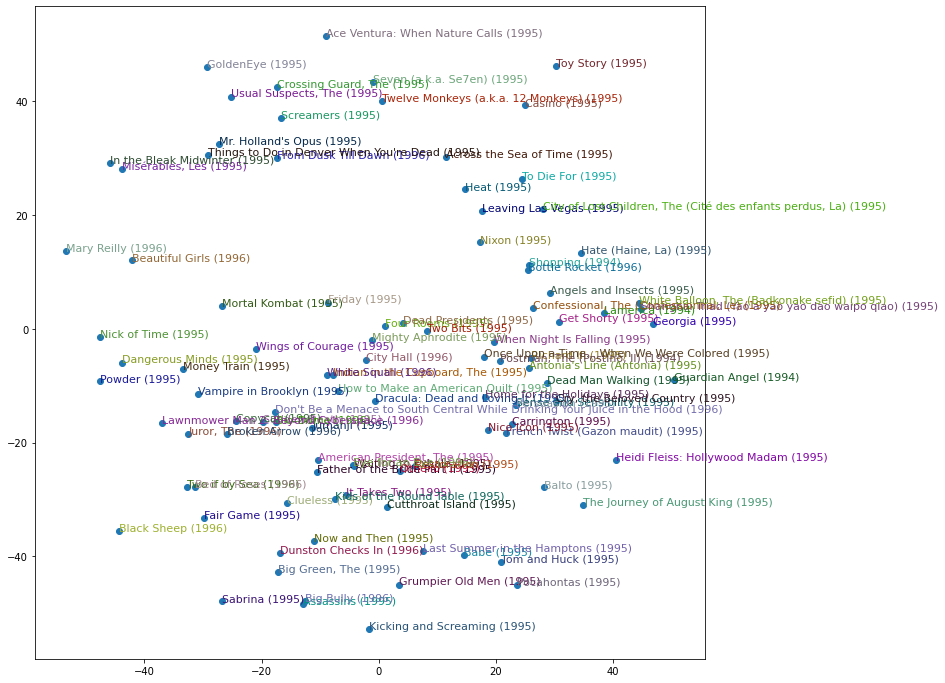

In [55]:
plt.figure(figsize=(12,12))
plt.scatter(df_movies_embeddings.tsne_0[:100], df_movies_embeddings.tsne_1[:100])
for i, x, y in zip(df_movies_embeddings.title[:100], df_movies_embeddings.tsne_0[:100], df_movies_embeddings.tsne_1[:100]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

In [63]:
from sklearn.cluster import KMeans
km = KMeans(100)
km.fit(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])
clusters = km.predict(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])

In [64]:
clusters

array([81, 80, 80, ..., 31, 31, 31], dtype=int32)

In [66]:
df_movies_embeddings["cluster_n10"] = clusters

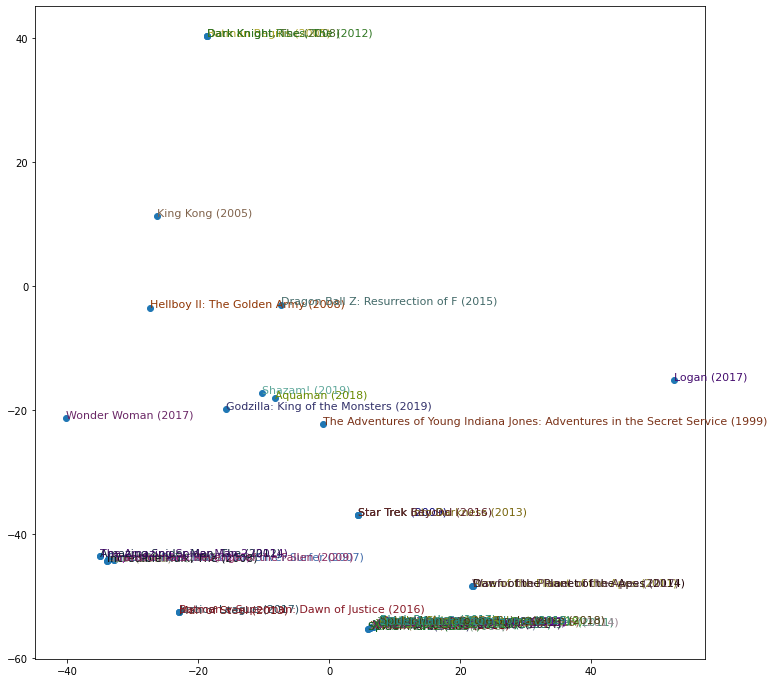

In [78]:
c = 26
plt.figure(figsize=(12,12))
plt.scatter(df_movies_embeddings.tsne_0[df_movies_embeddings.cluster_n10 == c], 
            df_movies_embeddings.tsne_1[df_movies_embeddings.cluster_n10 == c])
for i, x, y in zip(df_movies_embeddings.title[df_movies_embeddings.cluster_n10 == c], 
                   df_movies_embeddings.tsne_0[df_movies_embeddings.cluster_n10 == c], 
                   df_movies_embeddings.tsne_1[df_movies_embeddings.cluster_n10 == c]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

In [69]:
df_movies_embeddings.cluster_n10.value_counts(dropna=False).sort_values()

5         6
98        7
33        8
88        9
26       65
54      140
73      167
55      167
0       179
29      183
67      195
36      200
79      208
59      209
82      217
81      227
35      230
51      249
68      258
65      269
56      270
37      274
60      278
75      279
76      283
61      285
85      288
4       292
49      295
32      297
11      297
58      308
87      311
15      312
93      315
21      317
10      318
90      319
17      324
18      339
62      339
57      347
27      360
52      361
78      361
28      363
43      373
19      373
77      376
48      382
64      397
47      400
94      401
24      407
46      410
92      410
23      412
12      414
6       418
3       418
44      428
38      430
7       446
91      452
97      455
71      455
40      457
34      467
16      474
45      474
50      511
39      511
14      526
22      527
95      558
80      587
41      587
99      592
42      611
89      618
86      628
69      638
13      665
53  

In [74]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==88].title.unique()

array(['Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Star Wars: Episode I - The Phantom Menace (1999)',
       'Star Wars: Episode II - Attack of the Clones (2002)',
       'Star Wars: Episode III - Revenge of the Sith (2005)',
       "Empire of Dreams: The Story of the 'Star Wars' Trilogy (2004)",
       'Star Wars: Episode VII - The Force Awakens (2015)',
       'Rogue One: A Star Wars Story (2016)'], dtype=object)

In [75]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==5].title.unique()

array(['Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Hobbit: An Unexpected Journey, The (2012)',
       'Hobbit: The Desolation of Smaug, The (2013)',
       'The Hobbit: The Battle of the Five Armies (2014)'], dtype=object)

In [76]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==98].title.unique()

array(['Faces of Death 2 (1981)', 'Faces of Death (1978)',
       'Faces of Death 3 (1985)', 'Faces of Death 4 (1990)',
       'Faces of Death 5 (1996)', 'Faces of Death 6 (1996)',
       'Faces of Death: Fact or Fiction? (1999)'], dtype=object)

In [77]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==26].title.unique()

array(['X-Men (2000)', 'Spider-Man (2002)', 'X2: X-Men United (2003)',
       'Hulk (2003)', 'Spider-Man 2 (2004)', 'Batman Begins (2005)',
       'King Kong (2005)', 'X-Men: The Last Stand (2006)',
       'Superman Returns (2006)', 'Spider-Man 3 (2007)',
       'Fantastic Four: Rise of the Silver Surfer (2007)',
       'Transformers (2007)', 'Hellboy II: The Golden Army (2008)',
       'Dark Knight, The (2008)', 'Iron Man (2008)',
       'Incredible Hulk, The (2008)', 'X-Men Origins: Wolverine (2009)',
       'Star Trek (2009)', 'Transformers: Revenge of the Fallen (2009)',
       'Iron Man 2 (2010)', 'Thor (2011)', 'X-Men: First Class (2011)',
       'Captain America: The First Avenger (2011)',
       'Rise of the Planet of the Apes (2011)', 'Avengers, The (2012)',
       'Dark Knight Rises, The (2012)', 'Amazing Spider-Man, The (2012)',
       'Iron Man 3 (2013)', 'Star Trek Into Darkness (2013)',
       'Man of Steel (2013)', 'Wolverine, The (2013)',
       'Thor: The Dark World (2

In [79]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==54].title.unique()

array(['Screamers (1995)',
       'Tales from the Crypt Presents: Demon Knight (1995)',
       "Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)",
       'In the Mouth of Madness (1995)',
       'Candyman: Farewell to the Flesh (1995)',
       'Hellraiser: Bloodline (1996)',
       'Tales from the Crypt Presents: Bordello of Blood (1996)',
       'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)',
       'Amityville: A New Generation (1993)',
       'Amityville II: The Possession (1982)',
       'Nightmare on Elm Street, A (1984)', 'Event Horizon (1997)',
       'Wishmaster (1997)', 'Alien Escape (1995)',
       'Prophecy II, The (1998)',
       "Nightmare on Elm Street 2: Freddy's Revenge, A (1985)",
       'Nightmare on Elm Street 3: Dream Warriors, A (1987)',
       'Nightmare on Elm Street 4: The Dream Master, A (1988)',
       'Nightmare on Elm Street 5: The Dream Child, A (1989)',
       "Freddy's Dead: T